# Autoencoder para reconocimiento de digitos MNIST
Este ejemplo fue realizado para estudiar una red neuronal Autoencoder con 768 parámetros de entrada y distintas neuronas en la capa oculta, se aplicó descenso por gradiente estocástico como optimizador y tambien un dropout en las neuronas para evitar overfitting con el dataset.

Importo las librerias necesarias. Este notebook fue desarrollado en un entorno Windows, usando Visual Studio Code como editor, Nvidia CUDA 11, cuDNN Tensorflow 2.3 y Python 3.8.6. Para garantizar su correcto funcionamiento se instalaron los paquetes de forma manual y con un [wheel](https://github.com/fo40225/tensorflow-windows-wheel/tree/master/2.3.0/py38/CPU%2BGPU/cuda110cudnn8sse2) compilado especificamente para las versiones antes mencionadas.

In [1]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD


Importo el dataset y defino a las imágenes como un vector de 784 componentes y con valores normalizados para cada pixel. Asigno el conjunto de entrenamiento y test a ````x_train```` y ````x_test````

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Escribo la arquitectura de la red utilizando la API Funcional de Keras. La capa de entrada tiene 784 neuronas, establezco un dropout de 0.1, la capa oculta tendrá 64 neuronas y una activacion lineal. la capa de salida tiene 784 neuronas y una activacion relu. Muestro los modelos del autoencoder, encoder y decoder con summary()

In [3]:
encoding_dim = 64

input_img = keras.Input(shape=(784,))
encoded = layers.Dropout(0.1)
encoded = layers.Dense(encoding_dim, activation='linear')(input_img)


#decoded = layers.Dropout(0.1)
decoded = layers.Dense(784, activation='relu')(encoded)


autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()

encoder = keras.Model(input_img, encoded)
encoded_input = keras.Input(shape=(encoding_dim,))
encoder.summary()

decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
decoder.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
Total params: 50,240
Train

Para poder configurar mejor el optimizador es necesario especificar algunos parámetros, como el learning rate y el momento. También defino la métrica para luego poder realizar gráficas con el error cuadratico medio para cada epoca de entrenamiento.
Entreno la red con el conjunto de entrenamiento, especificando minibatchs de 1000 imágenes y 30 epocas.

In [4]:
sgd = SGD(learning_rate=0.0001, momentum=0.45)

autoencoder.compile(optimizer='sgd', loss='mse', metrics=['mean_squared_error'])

history = autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=60,
                verbose = 1,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1049 - mean_squared_error: 0.1049 - val_loss: 0.1026 - val_mean_squared_error: 0.1026
Epoch 2/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0976 - mean_squared_error: 0.0976 - val_loss: 0.0951 - val_mean_squared_error: 0.0951
Epoch 3/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0904 - mean_squared_error: 0.0904 - val_loss: 0.0877 - val_mean_squared_error: 0.0877
Epoch 4/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0837 - mean_squared_error: 0.0837 - val_loss: 0.0813 - val_mean_squared_error: 0.0813
Epoch 5/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0784 - mean_squared_error: 0.0784 - val_loss: 0.0767 - val_mean_squared_error: 0.0767
Epoch 6/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0745 - mean_squared_error: 0.0745 - val_loss: 0.0733 - val_mean_squared_error: 0.0733
Epoch 7/30
1000/

Para realizar la gráfica debo utilizar los datos almacenados en la variable history

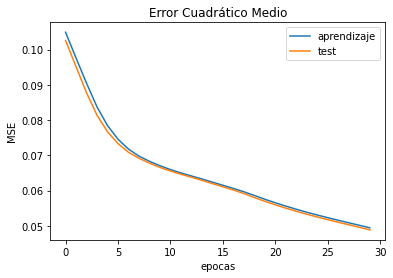

In [5]:
plt.plot(history.history['mean_squared_error'], label='aprendizaje')
plt.plot(history.history['val_mean_squared_error'], label='test')
plt.title('Error Cuadrático Medio')
plt.ylabel('MSE')
plt.xlabel('epocas')
plt.legend(loc="upper right")
#plt.savefig('ecm_of.eps',format='eps')
#plt.show()

Verificamos si la red aprendió a identificar los dígitos, pasamos el conjunto de entrenamiento al encoder y la salida al decoder, de esta manera obtenemos una prediccion con la dimensión original del archivo de entrada. Para que vuelva a ser una imagen debemos reconstruirla en una matriz de 28x28 e indicarle a matplotlib que es un mapa de bits correspondiente a una escala de grises.

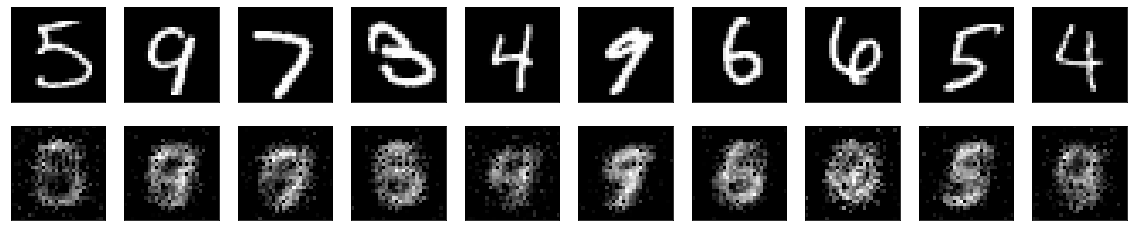

In [6]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+15].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+15].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Podemos agregar ruido al conjunto de test para visualizar la robustez del autoencoder para detectar patrones, si hubo overfitting la salida tambien contendrá un nivel similar de ruido.

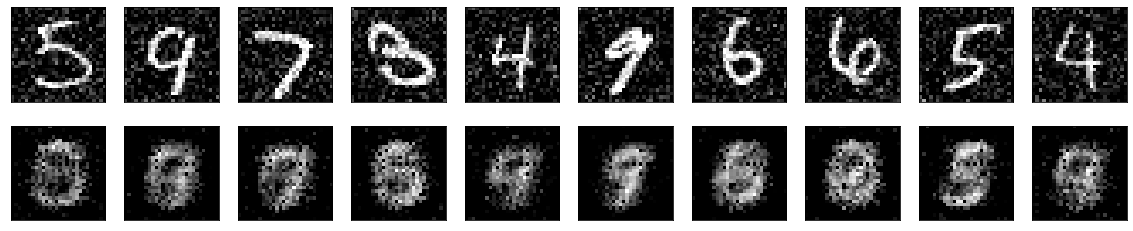

In [7]:
noise_factor = 0.2
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i+15].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+15].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Este es un breve ejemplo, para lograr el resultado deseado es necesario optimizar los hiperparámetros de la red. Si aumentamos el valor de la variable ````encoding_dim = 64```` a un numero mayor de neuronas, o cambiamos el valor del learning rate obtendremos resultados distintos. La optimizacion de redes neuronales es un arte, existen valores empíricos que han sido tomados como referencia en base a distintas investigaciones, pero si entendemos la topologia y los algoritmos involucrados podemos ajustar todo. Podemos correr cualquier red neuronal sólo copiando código ;), hay miles de ejemplos en la web o en la documentación de los desarrolladores de Keras, Tensorflow, Pytorch, etc.